In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tqdm import tqdm
from functools import reduce

from src.config import *
from src.prediction_functions import *
from src.model_creation import *


# Functions

In [3]:
def set_perturabtion_type_values(perturbation, pert_type_lists):
    if perturbation in pert_type_lists['compound_list']: perturbation_type = 'cp'
    elif perturbation in pert_type_lists['ligand_list']: perturbation_type = 'lig'
    elif perturbation in pert_type_lists['receptor_list']: perturbation_type = 'rec'
    else: perturbation_type = np.nan
    return perturbation_type

In [4]:
def determine_type_of_perturbation_of_samples(data_index, data_index_perturbation, pert_type_lists):
    pert_types = pd.DataFrame(columns = ['perturbation', 'perturbation_type'], dtype='str')
    pert_types['perturbation'] = data_index_perturbation
    pert_types['perturbation_type'] = pert_types['perturbation'].apply(lambda x: set_perturabtion_type_values(x, pert_type_lists)) 
    pert_types.index = data_index
    return pert_types

In [5]:
def calculate_roc_auc(estimated_activities, true_matrix):
    # for every ligand calculate rocauc
    rocaucs = {}
    for ligand in estimated_activities.columns:
        if true_matrix.loc[:, ligand].sum() < 1:
            print(ligand, ' not considered')
            continue
        rocaucs[ligand] = roc_auc_score(y_true = true_matrix.loc[:, ligand], y_score = estimated_activities.loc[:, ligand])
    return rocaucs

In [6]:
def calculate_roc_auc_sample(estimated_activities, true_matrix):
    # for every ligand calculate rocauc
    rocaucs = {}
    for sample in estimated_activities.index:
        if true_matrix.loc[sample, :].sum() < 1:
            print(sample, ' not considered')
            continue
        rocaucs[sample] = roc_auc_score(y_true = true_matrix.loc[sample, :], y_score = estimated_activities.loc[sample, :])
    return rocaucs

In [7]:
def plot_rocauc_violin(data):
    fig, ax = plt.subplots(figsize = (2,5))
    sns.violinplot(data = list(data.values()), orient = 'v', palette = 'Pastel1')
    plt.xlabel('ROCAUC')
    plt.axhline(0.5, color = 'k')
    plt.show()

In [8]:
def plot_rocauc_boxplot(data):
    fig, ax = plt.subplots(figsize = (2,5))
    sns.boxplot(data = list(data.values()), orient = 'v', palette = 'Pastel1')
    sns.swarmplot(data = list(data.values()), color="gray", alpha = 0.7)

    plt.xlabel('ROCAUC')
    plt.axhline(0.5, color = 'k')
    plt.ylim(-0.05,1.05)
    plt.show()

# START analysis

In [9]:
model_name = 'all'
model_type = 'multipl'

# Read in data

In [10]:
# read in lincs data - design matrix and signatures

In [11]:
lincs_consensus = pd.read_csv(f'data/lincs_consensus/high_quality/lm_all_pert_cell_liana.csv', index_col=0)
lincs_design_matrix = pd.read_csv(f'data/design_matrices/high_quality/all_pert_binary_liana.csv', index_col = 0)

# Calculate activities

In [12]:
train_indices, test_indices = train_test_split(lincs_consensus.index, test_size=0.5, random_state=2000)

In [13]:
train_consensus = lincs_consensus.loc[train_indices, :]
train_design_matrix = lincs_design_matrix.loc[train_indices, :]
test_consensus = lincs_consensus.loc[test_indices, :]
test_design_matrix = lincs_design_matrix.loc[test_indices, :]

In [16]:
# iterating 
def fit_linear_model_and_get_coefficients_by_receptor(y, X):
    # y = signature
    # X = model_matrix
    # fit linear model, y:signature, X:model matrix
    coeff_m = pd.DataFrame(columns=y.columns, index=[*X.columns])
    for gene in tqdm(list(y.columns)):
        for receptor in list(X.columns):
            Xj = X.loc[y.index, receptor]
            Xj = sm.add_constant(Xj)

            yi = y.loc[:, gene]

            assert(all(Xj.index == yi.index))
            model = sm.OLS(yi, Xj)
            results = model.fit()
            coeff_s = results.params
            assert len(coeff_s) == 2
            assert coeff_s.index[1]==receptor

            coeff_m.loc[receptor, gene] = coeff_s.loc[receptor]

    return coeff_m

In [58]:
coeff_train = fit_linear_model_and_get_coefficients_by_receptor(train_design_matrix, train_consensus)

100%|██████████| 229/229 [22:03<00:00,  5.78s/it]


In [59]:
coeff_train.to_csv(f'{DATA_DIR}/coefficient_matrix/high_quality/train_totalrandomsplit_pert_coef_liana.csv')

##### CytoSig

In [13]:
# data
cytosig_data = pd.read_csv(f'data/cytosig/diff.merge.gz', compression='gzip', sep = '\t')
cytosig_data = cytosig_data.T
cytosig_data = cytosig_data.fillna(0)

In [14]:
# predictions
# cacluate cytosig on lincs inferred genes consensus
# Created by running CytoSig_run.py -i input.csv -o output_filename
cytosig = {}
cytosig_lincs = pd.read_table(f'results/benchmark/cytosig_prediction_inferred_signature.Coef', sep = '\t')
cytosig['lincs'] = cytosig_lincs.T

In [15]:
# LINCS data
lincs_data = pd.read_csv(f'data/lincs_consensus/high_quality/lm_{model_name}_pert_cell_liana.csv', index_col = 0)


In [16]:
# LINCS model
lincs_model = pd.read_csv(f'data/coefficient_matrix/high_quality/{model_name}_pert_coef_liana.csv', index_col =0)
coeff_train = pd.read_csv(f'data//coefficient_matrix/high_quality/train_totalrandomsplit_pert_coef_liana.csv', index_col = 0)
lincs_model = lincs_model.T

In [17]:
lr_associations = pd.read_csv(LIG_REC_DF, index_col = 0)
lr_associations = lr_associations[['source_genesymbol', 'target_genesymbol']]

In [18]:
compound_info = pd.read_csv('data/filtered_lincs_meta/filtered_coumpound_info_to_receptor_perturbation_signatures_signed.csv', index_col =0)
compound_info = compound_info[['cmap_name', 'target', 'sign']].reset_index(drop=True)

## Data preparation

In [19]:
# Create perturbation metadata series
lincs_compounds_list = list(compound_info.cmap_name.unique())
lincs_ligand_list = list(lincs_data.index[(lincs_data.reset_index()['index'].str.split('_', expand = True)[2] == 'lig')].str.split('_', expand = True).get_level_values(0).unique())

In [20]:
pert_type_lists = {}
pert_type_lists['compound_list'] = lincs_compounds_list
pert_type_lists['ligand_list'] = list(lr_associations.source_genesymbol) + lincs_ligand_list
pert_type_lists['receptor_list'] = list(lr_associations.target_genesymbol)


# Matching data
- translating from ligand to receptor and vica versa

In [21]:
# lincs
tmp = lincs_data.index.str.split('_',expand = True).get_level_values(0)
lincs_pert_types = determine_type_of_perturbation_of_samples(lincs_data.index, tmp, pert_type_lists)
# cytosig
cytosig_pert_types = pd.DataFrame(columns = ['perturbation', 'perturbation_type'], index = cytosig_data.index)
cytosig_pert_types['perturbation_type'] = 'lig'
cytosig_pert_types['perturbation'] = cytosig_pert_types.index.str.split('@', expand = True).get_level_values(0).str.split('&', expand = True).get_level_values(0)
cytosig_pert_types['signed_interactions_lig'] = cytosig_pert_types.apply(lambda x: {x['perturbation']:1}, axis =1)

In [22]:
def get_target_list_cp(sample: pd.Series):
    drug = sample.perturbation
    target_dict = compound_info[compound_info['cmap_name'] == drug][['target', 'sign']].set_index('target')['sign'].to_dict()
    return target_dict

def get_target_list_lig(sample: pd.Series):

    receptors = list(lr_associations[lr_associations.source_genesymbol == sample.perturbation]['target_genesymbol'])
    if len(receptors) == 0:
        return np.nan
    
    # sample name PERT_CELL_PERTTYPE (eg. ACVR1_MCF7_oe)
    if (sample.name.split('_')[2] == 'oe'):
        target_dict = dict(zip(receptors, [1]*len(receptors)))
        return target_dict

    # sample name PERT_CELL_PERTTYPE (eg. ACVR1_MCF7_xpr)
    if (sample.name.split('_')[2] == 'xpr'):
        target_dict = dict(zip(receptors, [-1]*len(receptors)))
        return target_dict
    
    # sample name PERT_CELL_PERTTYPE (eg. ACVR1_MCF7_sh)
    if (sample.name.split('_')[2] == 'sh'):
        target_dict = dict(zip(receptors, [-1]*len(receptors)))
        return target_dict

    return np.nan

def get_target_list_rec(sample: pd.Series):
    # if receptor perturbation and overexpression add receptor to target dictionary with sign 1 
    # sample name PERT_CELL_PERTTYPE (eg. RPS19_MCF7_oe)
    if (sample.name.split('_')[2] == 'oe'):
        target_dict = {sample.perturbation:1}
        return target_dict

    # sample name PERT_CELL_PERTTYPE (eg. RPS19_MCF7_xpr)
    if (sample.name.split('_')[2] == 'xpr'):
        target_dict = {sample.perturbation:-1}
        return target_dict
    
    # sample name PERT_CELL_PERTTYPE (eg. RPS19_MCF7_sh)
    if (sample.name.split('_')[2] == 'sh'):
        target_dict = {sample.perturbation:-1}
        return target_dict

    return np.nan
    
def add_target_to_compound_lincs(sample):
    # if compoound perturbation add targets to target dictionary
    if sample.perturbation_type == 'cp':
       return get_target_list_cp(sample)

     # if ligand perturbation - fill return with receptor targets of ligands with sign (use lr_associations (LIANA))
    if sample.perturbation_type == 'lig':
        return get_target_list_lig(sample)
            
    if sample.perturbation_type == 'rec':
        return get_target_list_rec(sample)

    return np.nan
   

In [23]:
lincs_pert_types['signed_interactions_rec'] = lincs_pert_types.apply(lambda x: add_target_to_compound_lincs(x), axis = 1)


In [24]:
def filter_nan(dict):
  return {key: value for key, value in dict.items() if pd.notna(key) and pd.notna(value)}

In [25]:
def fill_signed_interactions_receptor(lig, sign):
    receptors = list(lr_associations[lr_associations['source_genesymbol'] == lig].target_genesymbol)
    if len(receptors) > 0:
        receptors = dict(zip(receptors, [sign]*len(receptors)))
        return receptors
    else:
        return {np.nan: np.nan}

In [26]:
def translate_ligand_to_receptor(sample_row):
    receptor_dict = dict(map(lambda sample: (sample[0], fill_signed_interactions_receptor(sample[0], sample[1])), sample_row.items()))
    flat_receptor_dict = reduce(lambda all, current: {**all, **filter_nan(current)}, receptor_dict.values(), {})
    if flat_receptor_dict == {}:
        return np.nan
    return flat_receptor_dict

In [27]:
def fill_signed_interactions_ligand(rec, sign):
    ligands = list(lr_associations[lr_associations['target_genesymbol'] == rec].source_genesymbol)
    if len(ligands) > 0:
        ligands = dict(zip(ligands, [sign]*len(ligands)))
        return ligands
    else:
        return {np.nan: np.nan}

In [28]:
def translate_receptor_to_ligand(sample_row):
    ligand_dict = dict(map(lambda sample: (sample[0], fill_signed_interactions_ligand(sample[0], sample[1])), sample_row.items()))
    flat_ligand_dict = reduce(lambda all, current: {**all, **filter_nan(current)}, ligand_dict.values(), {})
    if flat_ligand_dict == {}:
        return np.nan
    return flat_ligand_dict

In [29]:
cytosig_pert_types['signed_interactions_rec'] = cytosig_pert_types.apply(\
    lambda sample:translate_ligand_to_receptor(sample.signed_interactions_lig), axis = 1)

In [30]:
lincs_pert_types['signed_interactions_lig'] = lincs_pert_types.apply(\
    lambda sample: translate_receptor_to_ligand(sample.signed_interactions_rec)\
        if sample.perturbation_type!='lig' else {sample.perturbation:1}, axis = 1)

In [31]:
metadata = {}
metadata['lincs'] = lincs_pert_types
metadata['cytosig'] = cytosig_pert_types

# Prediction

# LINCS

In [32]:
results = {}
lincs = {}

In [44]:
if model_type == 'multipl':
    lincs['cytosig'] = estimation_with_zscore_calculation_in_chunks(cytosig_data, lincs_model, number_of_permutation=1000, chunk_size=300)
    lincs['lincs'] = estimation_with_zscore_calculation_in_chunks(test_consensus, coeff_train, number_of_permutation=1000, chunk_size=300)

Number of samples: 2056
Number of chunks: 7
Number of permutations: 1000


100%|██████████| 7/7 [02:05<00:00, 17.95s/it]


Number of samples: 7232
Number of chunks: 25
Number of permutations: 1000


100%|██████████| 25/25 [01:58<00:00,  4.74s/it]


In [ ]:
# lincs['cytosig'] = pd.read_csv('data/cytosig/lincs_predict_cytosig.csv', index_col = 0)

In [33]:
results['lincs'] = lincs

# CytoSig

In [34]:
results['cytosig'] = cytosig

# Create true matrices for ROCAUC analysis

In [35]:
def fill_tm(sample_row, perturbation_info, feature_pert_type):
    sample_row  = pd.Series(index = sample_row.index, name = sample_row.name, dtype = 'int')
    sample_id = sample_row.name

    perturbation_dict = perturbation_info.loc[sample_id, str('signed_interactions_'+feature_pert_type)]
    if pd.notna(perturbation_dict):
        for pert in perturbation_dict.keys():
            if pert in sample_row.index:
                sample_row.loc[pert] = perturbation_dict[pert]
    sample_row = sample_row.fillna(0)
    return sample_row

In [36]:
def create_true_matrices(prediction_results:dict, model:str, feature_pert_type:str, metadata:dict):
    print('Create true matrix for predictions of model: ', model)
    truem = {}
    for prediction in prediction_results[model]:
        print(prediction, end = ', ')
        perturbation_info = metadata[prediction]
        data = prediction_results[model][prediction].copy()
        truem[prediction] = data.apply(lambda sample: fill_tm(sample, perturbation_info, feature_pert_type), axis = 1)
    print('done')
    return truem
    

In [37]:
true_matrices = {}
true_matrices['lincs'] = create_true_matrices(prediction_results = results, model = 'lincs',feature_pert_type = 'rec', metadata = metadata)

Create true matrix for predictions of model:  lincs
done


In [38]:
results['cytosig']['lincs'] = results['cytosig']['lincs'].loc[metadata['lincs'].index]

In [39]:
true_matrices['cytosig'] = create_true_matrices(prediction_results = results, model = 'cytosig',feature_pert_type = 'lig', metadata = metadata)

Create true matrix for predictions of model:  cytosig
lincs, done


# Evaluation

In [40]:
def dropna_and_match(base, match):
    base2 = base.dropna(how = 'all')
    match2 = match.loc[base2.index]
    return base2, match2


In [41]:
def calculate_roc_auc(estimated_activities, true_matrix, printoutput= False):

    estimated_activities_matched, true_matrix_matched = dropna_and_match(estimated_activities, true_matrix)
    
    rocaucs = {}
    for ligand in estimated_activities_matched.columns:
        if true_matrix_matched.loc[:, ligand].sum() < 1:
            if printoutput: print(ligand, ' not considered')
            continue
        rocaucs[ligand] = roc_auc_score(y_true = true_matrix_matched.loc[:, ligand], y_score = estimated_activities_matched.loc[:, ligand])
    return rocaucs

In [42]:
def evaluate_with_signature_sign_change_if_inhibitory(activities, binary, printoutput = False, metric = 'ROC'):

    estimated_activities_matched, true_matrix_matched = dropna_and_match(activities, binary)

    print('Evaluation - calculate', metric, 'curves')
    receptors = list(set(activities.columns) & set(binary.columns))
    binary.index  = binary.index.astype('str')
    filtered_activities  = activities.loc[binary.index, receptors]
    filtered_binary = binary.loc[filtered_activities.index,receptors]
    

    metric_results = dict()
    for receptor in filtered_binary.columns:
        sign_changed_activities = filtered_activities.copy()
        sign_changed_binary = filtered_binary.copy()
    
        inhibitory_samples = filtered_binary.loc[(filtered_binary.loc[:, receptor] == -1).values].index
        sign_changed_activities.loc[inhibitory_samples] = sign_changed_activities.loc[inhibitory_samples] * (-1)
        sign_changed_binary.loc[inhibitory_samples, receptor] = 1
        # filter out receptors that are not perturbed in any of the experiments
        if sign_changed_binary.loc[:, receptor].sum() == 0:
            continue
        if metric == 'ROC':
            # rate1: fpr, rate2: tpr
            fpr, tpr, _ = roc_curve(y_true = sign_changed_binary.loc[:, receptor], y_score = sign_changed_activities.loc[:, receptor])
            metric_results[receptor] = auc(fpr, tpr)

        elif metric == 'PR':
            # rate1: precision, rate2: recall
            prec, recall, _ = precision_recall_curve(y_true = sign_changed_binary.loc[:, receptor], probas_pred = sign_changed_activities.loc[:, receptor])
            metric_results[receptor] = auc(prec, recall)

        else:
            raise "No such metric."

    return metric_results

In [43]:
rocaucs = {}
for model in results:
    print('--> Model:', model)
    dataset_rocaucs = {}
    for dataset in results[model]:
        print('Dataset:', dataset, end = '\t')
        dataset_rocaucs[dataset] = evaluate_with_signature_sign_change_if_inhibitory(results[model][dataset], true_matrices[model][dataset], metric = 'ROC', printoutput = False)

    rocaucs[model] = dataset_rocaucs
print('Done')

--> Model: lincs
--> Model: cytosig
Dataset: lincs	Evaluation - calculate ROC curves
Done


# Plot

In [44]:
def create_table_to_plot(rocaucs):
    res_df = pd.DataFrame(columns= ['model', 'dataset', 'auc'])
    for model in rocaucs:
        for dataset in rocaucs[model]:
            dataset_rocaucs = pd.DataFrame(columns= res_df.columns)
            dataset_rocaucs.auc = list(rocaucs[model][dataset].values())
            dataset_rocaucs.model = model
            dataset_rocaucs.dataset = dataset
            res_df = pd.concat([res_df, dataset_rocaucs])
    return res_df

In [45]:
def add_median_labels(ax, fmt='.2f'):
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

In [46]:
def plot_results(results:pd.DataFrame, evaluation_metric = 'ROCAUC', save = False, filename = ''):
    fig, ax = plt.subplots(figsize = (3,5), facecolor='white')
    boxp = sns.boxplot(data = results, x = 'model', y = 'auc', hue = 'dataset', palette = 'Blues_r') # hue = 'dataset'
    scp = sns.stripplot(data = results, x = 'model', y = 'auc', hue = 'dataset', color = 'k', alpha = 0.3, dodge = True) # hue = 'dataset
    add_median_labels(boxp)
    plt.axhline(0.5, color= 'k')
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel(evaluation_metric, fontsize = 16)
    plt.xlabel('Model', fontsize = 16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    # show only bixplot legend
    handles, labels = ax.get_legend_handles_labels()
    length = len(results.dataset.unique())
    l = plt.legend(handles[0:length], labels[0:length], loc = 'upper left', title = 'dataset')
    if save:
        if filename=='': raise "No filename was given."
        # plt.savefig(f'{FIGURES_DIR}model_summary/cytosig/{filename}.png', dpi = 200, bbox_inches = 'tight', transparent = False)
        plt.savefig(f'{FIGURES_DIR}/model_summary/cytosig/{filename}.pdf', bbox_inches = 'tight', transparent = True)


In [47]:
rocaucs_dataframe = create_table_to_plot(rocaucs)

In [125]:
rocaucs_dataframe.to_csv(f'results/benchmark/cytosig_lincs_rocauc.csv')

In [126]:
table = rocaucs_dataframe.groupby(by=['model', 'dataset']).median().sort_values(by='auc', ascending = False)
table

auc
model   dataset          
lincs   lincs    0.641130
        cytosig  0.603171
cytosig lincs    0.527907

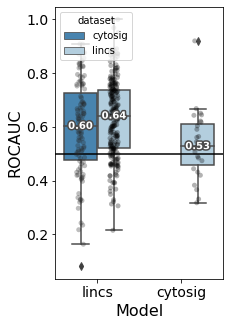

In [133]:
plot_results(rocaucs_dataframe, evaluation_metric = 'ROCAUC', save = False, filename = f'cytosig_ROCAUC_comparison_blue')